**Abhina Premachandran Bindu**

**May 6 2024**

# Preprocessing the dataset using Gensim Library
  <p> The goal of this notebook is to explain the working of the classifier. A Decision Tree classifier is used to fit and train on the word embeddings. To understand the working of the classifier, shap plots are used for individual test data. Further, the feature importance is found using the feature_importances_ attribute of the DecisionTree classifier. </p>
  
  
## Loading and initial cleaning of data

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing nlp
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# importing sklearn for model building
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report

# importing shap
import shap
shap.initjs()

In [2]:
# combining the two separate csv files with fake and real data to a single dataframe 
# df1 --> Fake , df2 --> Real
df1 = pd.read_csv(input("Enter the file path for the fake dataset"))
df2 = pd.read_csv(input("Enter the file path for the real dataset"))

# adding the labels Fake --> 0 and Real --> 1
df1['target'] = 0
df2['target'] = 1

Enter the file path for the fake dataset/Users/abhinapremachandran/Desktop/Spring '24 CCNY/Machine Learning/group_project_ML/Fake.csv
Enter the file path for the real dataset/Users/abhinapremachandran/Desktop/Spring '24 CCNY/Machine Learning/group_project_ML/True.csv


In [3]:
# combining the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)
# shuffling the indices
data = combined_df.sample(frac=1, random_state=42)
data.reset_index(inplace=True, drop=True)
print(data.head())

                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  target  
0    February 13, 2017       0  
1       April 5, 2017        1  
2  September 27, 2017        1  
3         May 22, 2017       0  
4       June 24, 2016        1  


In [4]:
data.head()

,title,text,subject,date,target
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [6]:
# checking the value counts of 'target' to check for data imbalance
data.target.value_counts()

0    23481
1    21417
Name: target, dtype: int64

 Since the number of Fake and True classes are almost same, there is no class imbalance

In [7]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

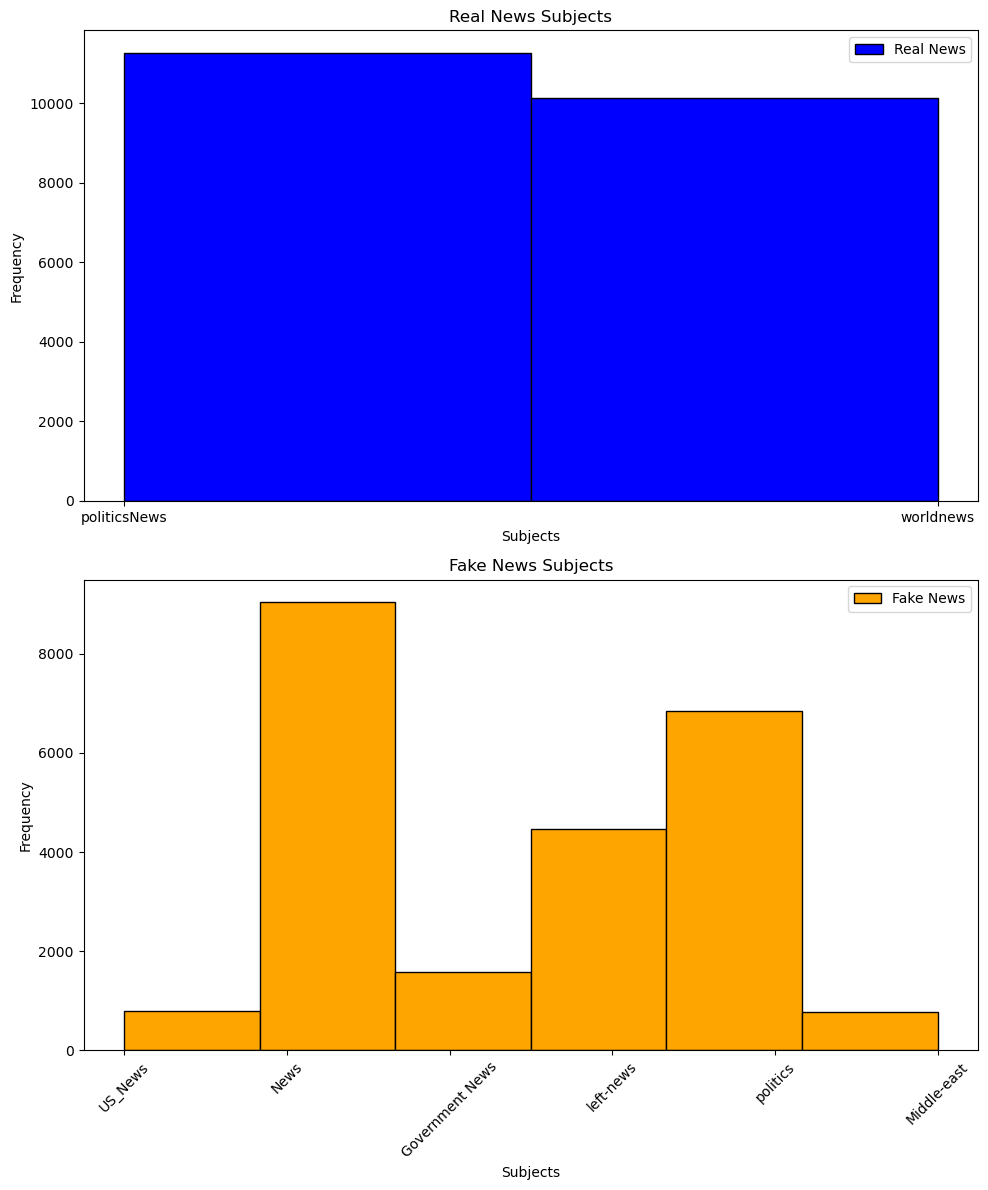

In [21]:
# visualize the distribution of subjects
data_real = data[data['target']==1]
data_fake = data[data['target']==0]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
# Plot the most frequent words in real news on the first subplot
axs[0].hist(data_real['subject'], bins=len(data_real.subject.unique()), align = 'mid', edgecolor='black', color='blue')
axs[0].set_xlabel('Subjects')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Real News Subjects')
axs[0].tick_params(axis='x') 
axs[0].legend(['Real News'])

axs[1].hist(data_fake['subject'], bins=len(data_fake.subject.unique()), align = 'mid', edgecolor='black', color = 'orange')
axs[1].set_xlabel('Subjects')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Fake News Subjects')
axs[1].tick_params(axis='x', rotation=45) 
axs[1].legend(['Fake News'])
plt.tight_layout()
plt.show()

## Data Preprocessing

### cleaning and tokenizing

In [10]:
# Tokenize and removing stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # remove non-alphabetical characters and stopwords
    cleaned_tokens = [re.sub(r'[^a-zA-Z ]', '', text).lower() for text in tokens if text.lower() not in stop_words]
    cleaned_tokens = [token for token in cleaned_tokens if ((token not in  set(string.punctuation)))]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in cleaned_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    #stem the tokens
    porter = PorterStemmer()
    cleaned_text = " ".join(porter.stem(token) for token in processed_text.split())
    return cleaned_text

# Apply the function across the DataFrame
data['cleaned_text'] = data['text'].apply(clean_text)

In [11]:
data.tail()

,title,text,subject,date,target,cleaned_text
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0,
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1,londontokyo reuter british prime minist theres...
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1,berlin reuter chancellor angela merkel said ge...
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0,jesu f cking christ presid moron satisfi simpl...
44897,BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...,IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...,politics,"Apr 23, 2015",0,toast bigger troubl thought much whole thing g...


## Classifying the data using DecisionTreeClassifier

In [13]:
# defining X and y arrays
# X = word_vectors
X = data['cleaned_text'].values
y = data['target'].values

In [14]:
# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

In [15]:
# defining the Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [16]:
# defining the classification model
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train_vec,y_train)

DecisionTreeClassifier()

In [17]:
# predicting the test values
y_pred = tree_clf.predict(X_test_vec)
# printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7649
           1       0.99      0.99      0.99      7168

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



## Understanding the classification model

### 1. Using Shap

In [18]:
# getting the feature names from tfidf vectorizer
feature_names = vectorizer.get_feature_names_out()
# getting the shap values
explainer = shap.Explainer(tree_clf, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape)

 99%|===================| 29255/29634 [00:50<00:00]        

(14817, 16341, 2)


harrisburg pa reuter u presid donald trump hit road saturday celebr first day white hous cheer support campaignstyl ralli tout initi achiev lash critic trump told pennsylvania crowd get start meet campaign promis repeatedli attack incompet dishonest medium say tell truth administr accomplish administr deliv everi singl day great citizen countri trump said harrisburg pennsylvania keep one promis anoth frankli peopl realli happi it ralli occur day climat march thousand protest surround white hous also coincid annual blackti white hous press dinner washington trump staff chose skip press dinner said unfair treatment press trump said thrill away washington swamp larg group hollywood actor washington medium consol hotel ballroom nation capit right trump said loud boo crowd medium job honest tell truth medium deserv big fat fail grade trump list said key earli accomplish includ success confirm u suprem court justic neil gorsuch clear away mani regul environ busi also list approv keyston xl d

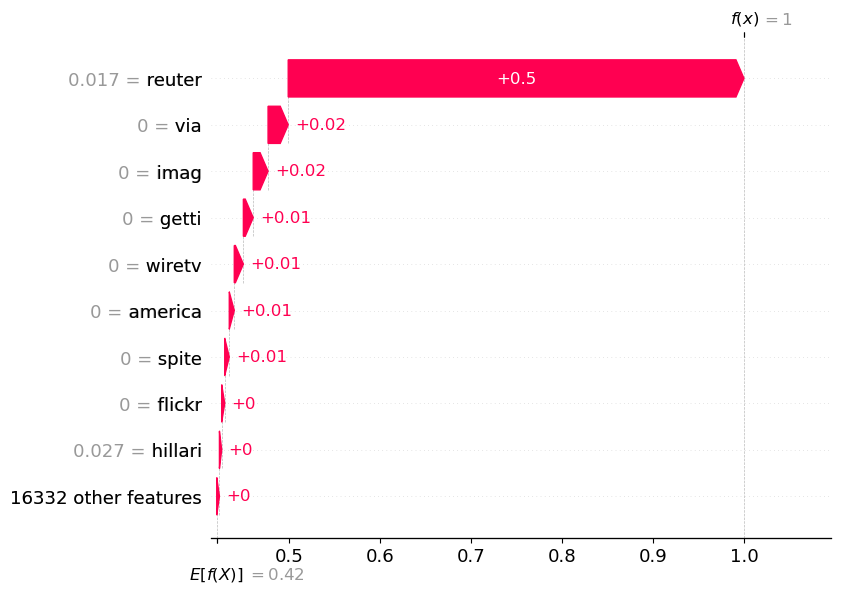

In [19]:
# getting the shap waterfall plot for the 7th test data
shap.initjs()

ind = 6
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

madonna took instagram late thursday promot upcom antidonald trump protest march share photo woman shoe compani nike logo appar shave public hair yasssssssss nakidmagazin madonna wrote ad million woman march washington dc jan yasssssssss nakidmagazin million woman s march washington dc jan photo mariu sperlicha post share madonna madonna jan pm psta breitbart news previous report thousand woman expect travel nation capit woman march washington protest presidentelect donald trump inaugurationth organ said want event send bold messag new administr first day offic world woman right human right earlier week singer kati perri cher actress scarlett johansson zendaya debra mess juliann moor announc expect particip januari eventth yearold rebel heart singer spent month slam trump campaign drum support hillari clinton octob madonna famous offer oral sex anyon vote former democrat nomineelast month madonna admit trump elect left devast entir stori breitbart


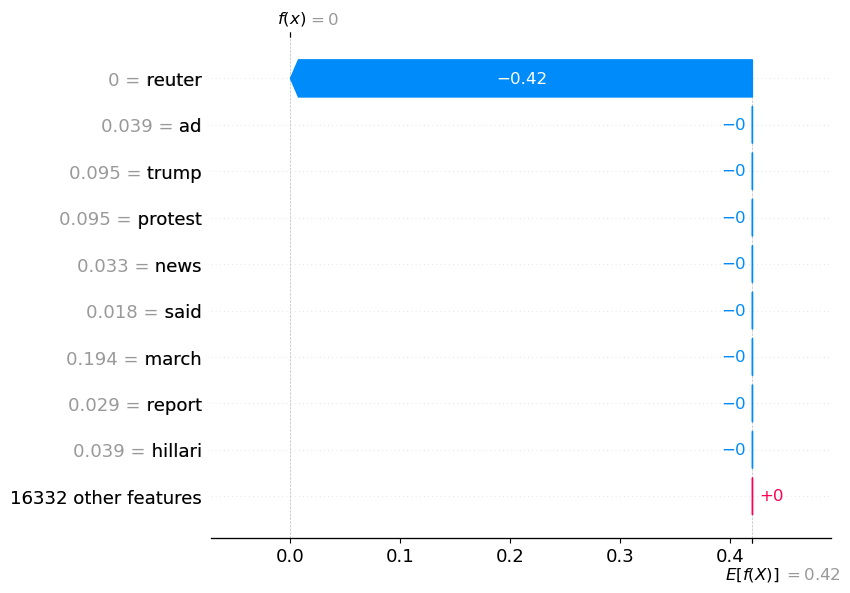

In [20]:
# getting the shap waterfall plot for the 11th test data
shap.initjs()

ind = 10
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

washington reuter presid barack obama visit cuba later month affect cancel tent plan secretari state john kerri visit island nation human right talk beforehand white hous said friday top u diplomat told congression hear feb might cuba dialogu human right presid schedul trip march offici said thursday kerri visit cancel amid concern cuba human right record white hous said friday kerri decis would affect obama visit kerri would travel cuba presid


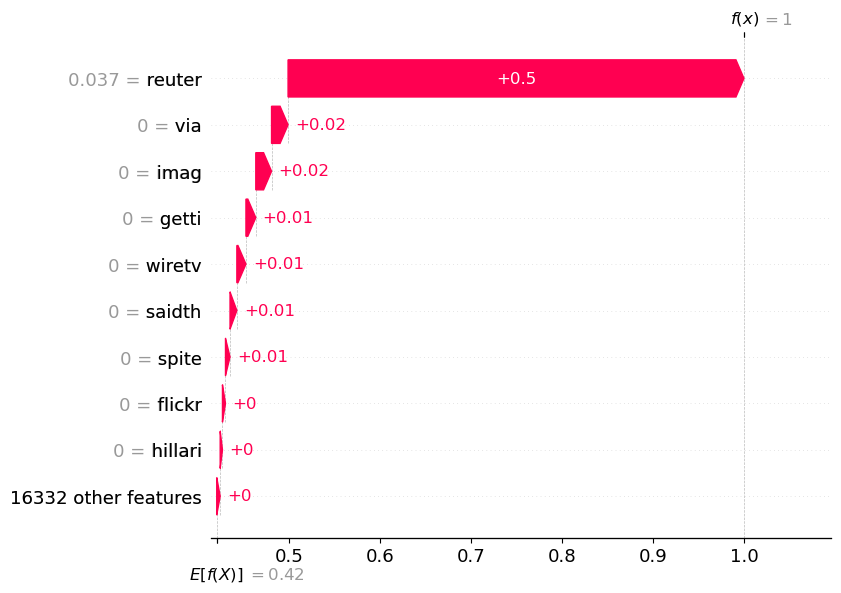

In [21]:
# getting the shap waterfall plot for the 201st test data
shap.initjs()

ind = 200
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

  From the three waterfall plots above, it is clear that the model uses the word 'reuter' as the primary indicator of whether a text classifies as fake or real. If the shap value of 'reuter' is greater than 0, it classifies the text as real and vice versa.

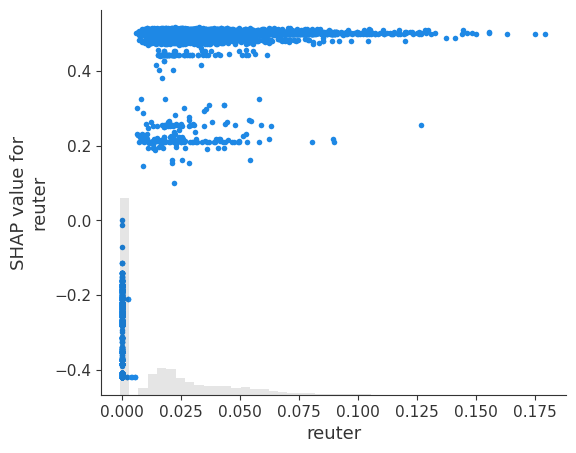

In [22]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("reuter"),1])

The above plot shows how the 'reuter' feature influences the model in predicting an object as class 1 - real. Most of the shap values for this feature lies closer to 0.5 implying its importance for the classifier in predicting classes as real.

### 2. Using Decision Tree classifier features

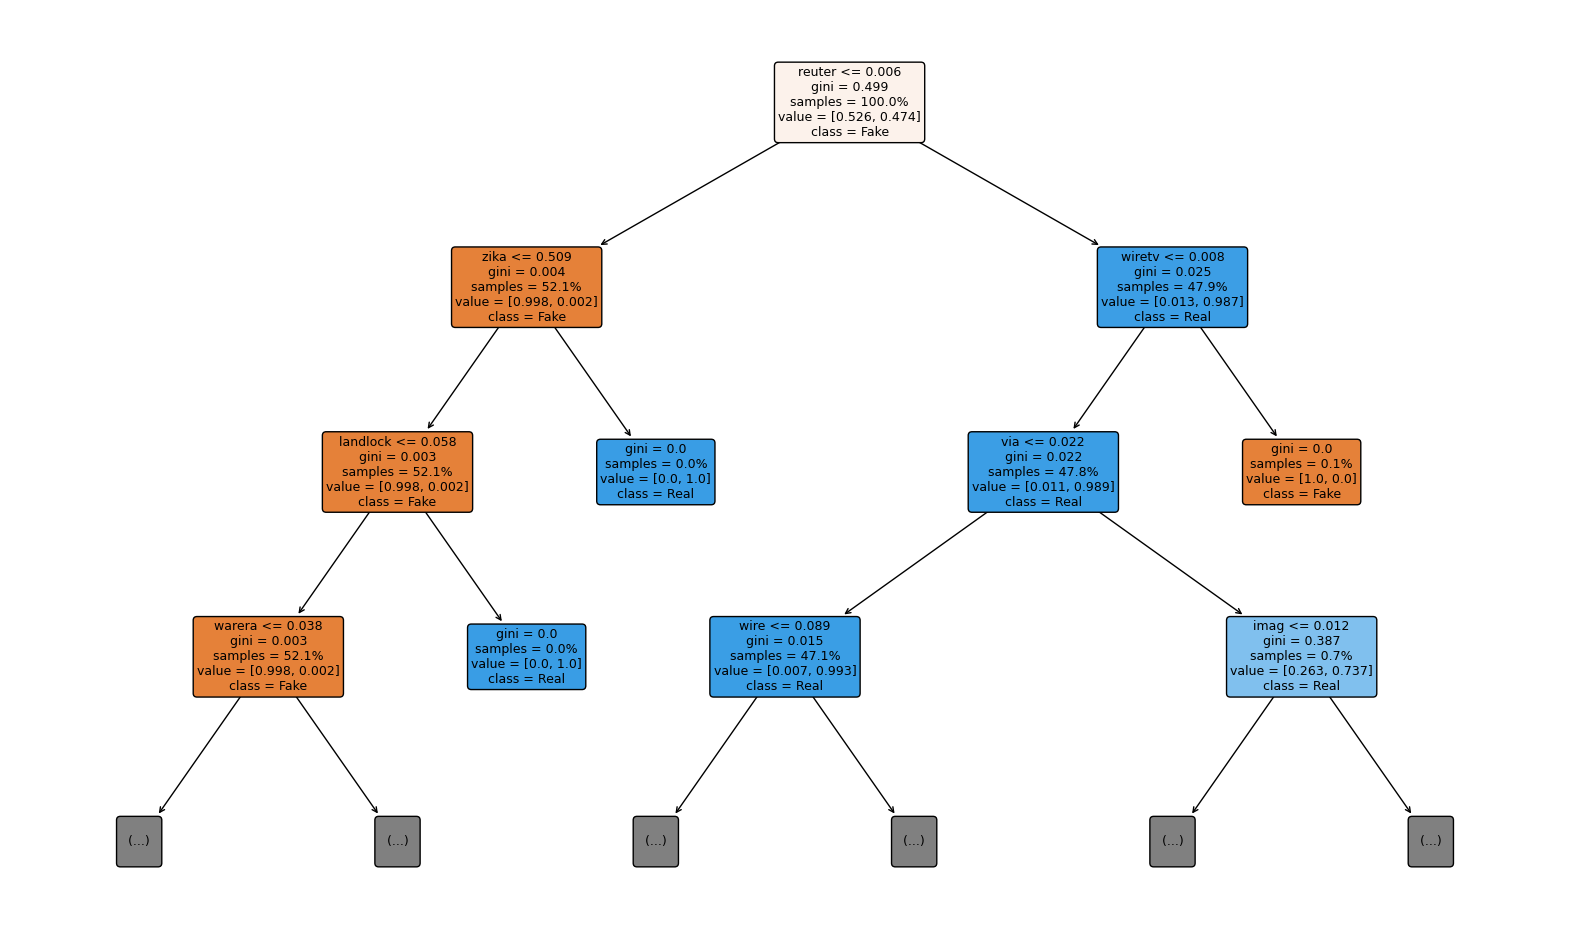

In [23]:
class_names = ["Fake", "Real"]

fig = plt.figure(figsize=(20, 12))
vis = tree.plot_tree(
    tree_clf,
    class_names=class_names,
    feature_names = vectorizer.get_feature_names_out(),
    max_depth=3,
    fontsize=9,
    proportion=True,
    filled=True,
    rounded=True
)
plt.show()


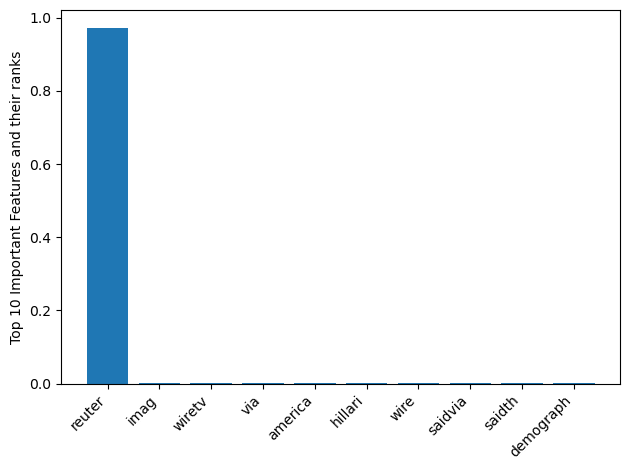

In [30]:
feature_names = vectorizer.get_feature_names_out()
feature_importance = tree_clf.feature_importances_
inds = np.argsort(np.abs(feature_importance))[::-1]
top_10_inds = inds[:10]
fig, ax = plt.subplots()
rank = np.arange(10)
ax.bar(rank, feature_importance[top_10_inds])
ax.set_xticks(rank)
ax.set_xticklabels(np.array(feature_names)[top_10_inds], rotation=45, ha='right')
ax.set_ylabel("Top 10 Important Features and their ranks")
plt.tight_layout()
plt.show()

  The above tree visualization of the classifier indicates that the classifier uses 'reuter' feature as one of the main feature to decide whether the text is fake or real. In the next level, 'zika' and 'wiretv' are used to split the data into the respective classes based on certain threshold values for the features. The bar chart on the feature importance also indicates that the 'reuter' feature have a huge significance in influencing the model decision compared to other features. 